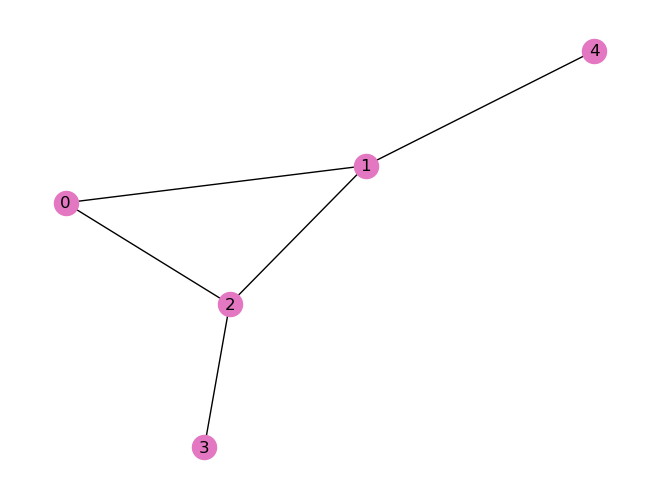

Cost Hamiltonian
0.75 * (Z(0) @ Z(3)) + -0.75 * Z(0) + -0.75 * Z(3) + 0.75 * (Z(0) @ Z(4)) + -0.75 * Z(0) + -0.75 * Z(4) + 0.75 * (Z(1) @ Z(3)) + -0.75 * Z(1) + -0.75 * Z(3) + 0.75 * (Z(2) @ Z(4)) + -0.75 * Z(2) + -0.75 * Z(4) + 0.75 * (Z(3) @ Z(4)) + -0.75 * Z(3) + -0.75 * Z(4) + 1.0 * Z(0) + 1.0 * Z(1) + 1.0 * Z(2) + 1.0 * Z(3) + 1.0 * Z(4)
Driver Hamiltonian
1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3) + 1 * X(4)
(1.5+0j) * (Y(0) @ Z(3)) + (-1+0j) * Y(0) + (1.5+0j) * (Y(0) @ Z(4)) + (1.5+0j) * (Y(1) @ Z(3)) + (0.5+0j) * Y(1) + (1.5+0j) * (Y(2) @ Z(4)) + (0.5+0j) * Y(2) + (1.5+0j) * (Z(0) @ Y(3)) + (-2.5+0j) * Y(3) + (1.5+0j) * (Z(1) @ Y(3)) + (1.5+0j) * (Y(3) @ Z(4)) + (1.5+0j) * (Z(0) @ Y(4)) + (-2.5+0j) * Y(4) + (1.5+0j) * (Z(2) @ Y(4)) + (1.5+0j) * (Z(3) @ Y(4))
第 1 步: E = 0.00000000 Ha, β_1 = -0.000000
第 2 步: E = -0.21541819 Ha, β_2 = -0.350569
第 3 步: E = -0.65018369 Ha, β_3 = -0.606609
第 4 步: E = -1.09976810 Ha, β_4 = -0.686280
第 5 步: E = -1.41333206 Ha, β_5 = -0.605943
第 6 步: E =

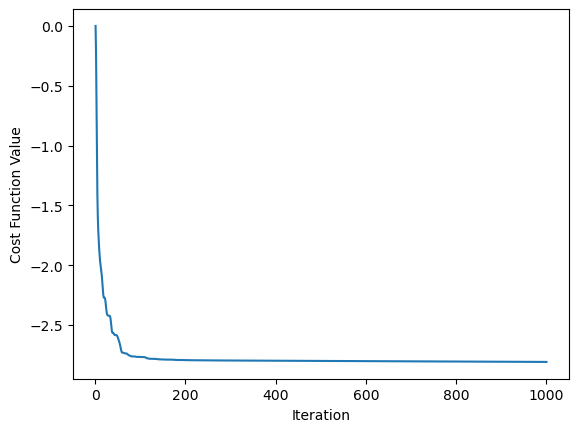

NameError: name 'build_maxclique_ansatz' is not defined

In [10]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from pennylane import qaoa as qaoa
import networkx as nx
from pennylane import commutator

edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4)] #Defines the list of edges that will make up the graph. Each pair has a connection between two nodes.
graph = nx.Graph(edges) #Creates an undirected graph (Graph) object from the given edge list using NetworkX.   undirected graph :A to B, B to A
positions = nx.spring_layout(graph, seed=1) #Calculates the layout (node positions) using the spring layout algorithm.Set Random seed=1 ensures consistent layout every time.
nx.draw(graph, with_labels=True, node_color="#e377c2", pos=positions) #show node labels,set node color to pink,use the previously calculated layout
plt.show()

cost_h, driver_h = qaoa.max_clique(graph, constrained=False)

print("Cost Hamiltonian")
print(cost_h)
print("Driver Hamiltonian")
print(driver_h)

def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except Exception as e:
                print(f"跳过 [{op1}, {op2}]：{e}")
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, cost_h)
print(comm_h)

comm_h = build_commutator_hamiltonian(driver_h, cost_h)

# 5. 初始化量子态：|+>^n
qubits=5
dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev)
def plus_state():
    for w in range(qubits):
        qml.Hadamard(w)
    return qml.state()

# 6. 单步 FALQON 演化矩阵
def single_falqon_unitary(beta_k, delta_t, cost_h, driver_h):
    U_cost = qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    U_driver = qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)
    return qml.matrix(U_driver @ U_cost, wire_order=range(qubits))

# 7. 测量期望值 ⟨ψ|H|ψ⟩
def measure_expectation(state, H):
    H_mat = qml.matrix(H, wire_order=range(qubits))
    return np.real(np.vdot(state, H_mat @ state))

# 8. 主流程：状态保留式 FALQON
def run_fbqa_state_tracking(H, driver_h, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    state = plus_state()

    for i in range(n_steps):
        # 计算 feedback beta
        exp_comm = measure_expectation(state, comm_h)
        next_beta = -delta_t * exp_comm
        beta_list.append(next_beta)

        # 应用下一步 unitary
        U_k = single_falqon_unitary(next_beta, delta_t, H, driver_h)
        state = U_k @ state

        # 计算能量
        energy = measure_expectation(state, H)
        energy_list.append(energy)

        print(f"第 {i+1} 步: E = {energy:.8f} Ha, β_{i+1} = {next_beta:.6f}")

    return beta_list, energy_list

# 9. 设置参数并运行
n = 1000
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa_state_tracking(cost_h, driver_h, comm_h, n_steps, beta_1, delta_t)

plt.plot(range(n+1)[1:], res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.show()

@qml.qnode(dev, interface="autograd") #this line wraps the "prob_circuit" function into a QNode,runs it on the "dev" device, and uses the "autograd" interface for differentiation
def prob_circuit(): #to compute measurement probabilities
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t) #use the "build_maxclique_ansatz" function to construct the parameterized quamtum circuit for the MaxClique problem
    ansatz(res_beta) #Apply the optimized feedback parameters "res_beta" to build the final evolved quantum state
    return qml.probs(wires=dev.wires) #return the probabilities of all possible bitstrings over qubits 


probs = prob_circuit()
plt.bar(range(2**len(dev.wires)), probs)
plt.xlabel("Bit string")
plt.ylabel("Measurement Probability")
plt.show()


graph = nx.Graph(edges)
cmap = ["#00b4d9"]*3 + ["#e377c2"]*2
positions = nx.spring_layout(graph, seed=1)
nx.draw(graph, with_labels=True, node_color=cmap, pos=positions)
plt.show()